# Symbolic regression monobjective for slow solar wind

#### 1. Libraries importation

In [2]:
import math
from tqdm import tqdm
import random
import csv
import datetime
import time
import numpy
import operator
import matplotlib.pyplot as plt
import multiprocessing
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import pandas as pd
from deap import algorithms, base, creator , tools, gp
from sympy import sympify, sin, cos, simplify
import operations
import evaluators

#### 2. CSV importation and analysis

In [21]:
slow_wind = pd.read_csv(r'C:\Users\Christian Mariscal\Documents\TFM\venv_TFM\gp_data\slow_model_io.csv', delimiter = ',')
forecast = slow_wind['forecast']
slow_wind = slow_wind.drop(['Unnamed: 0', 'forecast'], axis = 1)

In [3]:
#slow_wind.head()

In [4]:
#forecast.head()

In [22]:
slow_wind.describe()

,Bt_carrington_4,Bx_carrington_4,By_carrington_4,Bz_carrington_4,speed_carrington_4,p_density_carrington_4,temperature_carrington_4,Bt_1d_4,Bx_1d_4,By_1d_4,...,speed_carrington_1,p_density_carrington_1,temperature_carrington_1,Bt_1d_1,Bx_1d_1,By_1d_1,Bz_1d_1,speed_1d_1,p_density_1d_1,temperature_1d_1
count,3177.000000,3177.000000,3177.000000,3177.000000,3177.000000,3177.000000,3177.000000,3177.000000,3177.000000,3177.000000,...,3177.000000,3177.000000,3177.000000,3177.000000,3177.000000,3177.000000,3177.000000,3177.000000,3177.000000,3177.000000
mean,5.220436,0.064686,-0.096858,-0.015642,390.687629,6.761182,70080.161922,5.104943,0.081620,-0.095475,...,407.540762,6.544147,81000.196634,4.856785,0.026615,-0.049001,0.010868,377.120876,6.501529,57023.690798
std,2.227037,2.233411,2.555328,1.441341,71.638030,3.680479,53943.485749,1.988581,2.268103,2.504693,...,86.187587,3.730064,61296.545822,1.898433,2.081985,2.437871,1.375768,52.239540,3.432157,33156.434956
min,1.647877,-9.592659,-10.856756,-11.299399,258.522174,0.244214,10338.339024,1.647877,-8.239690,-9.332319,...,258.522174,0.244214,10338.339024,1.647877,-8.239690,-10.856756,-11.299399,258.522174,0.244214,10338.339024
25%,3.721164,-1.646521,-1.960250,-0.567868,339.985874,4.076180,33640.266667,3.769197,-1.722411,-1.943733,...,344.002068,3.835058,37034.018349,3.617875,-1.579088,-1.849703,-0.517517,338.498085,3.967893,32522.349138
50%,4.674053,0.106701,-0.216942,-0.030740,375.508828,5.927317,54596.143767,4.648517,0.105235,-0.273552,...,388.109683,5.657405,62614.484501,4.458709,0.030354,-0.139336,0.003087,371.562267,5.752926,50143.747715
75%,6.127326,1.714542,1.753328,0.524004,425.159521,8.691359,87762.024038,5.987109,1.829367,1.780827,...,451.955211,8.488587,106218.827402,5.662033,1.587659,1.759863,0.530958,411.261679,8.344155,74882.515454
max,20.605603,14.119685,12.850778,11.444558,739.879339,37.717043,527426.982720,20.605603,14.119685,12.850778,...,756.381116,37.717043,575373.272103,20.501615,12.061417,12.850778,11.444558,585.311066,29.660255,445856.918191


In [23]:
forecast.describe()

count    3177.000000
mean      370.129375
std        39.757616
min       262.731249
25%       339.009226
50%       368.833603
75%       400.397979
max       449.935003
Name: forecast, dtype: float64

In [7]:
#slow_wind.info()

In [8]:
#forecast.info()

#### 3. Defining primitive set

In [19]:
#Second argument = number of variables in problem (this case, 56 vars)
pset = gp.PrimitiveSet("MAIN", 56)
#Second argument = arity
pset.addPrimitive(operations.add, 2)
pset.addPrimitive(operations.sub, 2)
pset.addPrimitive(operations.mul, 2)
pset.addPrimitive(operations.protectedDiv, 2)
pset.addPrimitive(operations.cos, 1)
pset.addPrimitive(operations.sin, 1)
pset.addPrimitive(operations.tan, 1)
pset.addPrimitive(operations.asin, 1)
pset.addPrimitive(operations.acos, 1)
pset.addPrimitive(operations.atan, 1)
pset.addPrimitive(operations.log10, 1)
pset.addPrimitive(operations.log, 1)
pset.addPrimitive(operations.sqrt, 1)
pset.addPrimitive(operations.exp, 1)
pset.addPrimitive(operations.pow, 2)

pset.addEphemeralConstant("rand101", lambda: random.randint(-1000,1000))
pset.addEphemeralConstant("pi", lambda: math.pi)
pset.addEphemeralConstant("e", lambda: math.e)

#Renaming arguments
renArg = dict(zip(pset.arguments, list(slow_wind.columns)))
pset.renameArguments(**renArg)


In [10]:
def avgAbsError(individual, dataframe, forecast):
    
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    
    # Evaluate the mean squared error between the expression and the real function
    AvgAbsError = [abs(func(*dataframe.iloc[nrow]) - forecast[nrow]) for nrow in random.sample(range(len(dataframe)), int(len(dataframe)/2))]

    return sum(AvgAbsError) / len(AvgAbsError),

#### 4. Parameters definition

In [11]:
#Defining fitness class
creator.create("FitnessMin", base.Fitness, weights=(-1,))

#Defining individuals shape and associating fitness attribute
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

#Creating toolbox to register: population creation, evaluation function, selection mecanism
#and genetic operators
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", avgAbsError, dataframe=slow_wind, forecast=forecast)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=20))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=20))

#### 5. Algorithm initialization

In [12]:
def StatsToCsv(StatsDF):
    replacement = [' ',':','.']
    date=datetime.datetime.now()
    for sign in replacement:
        date = str(date).replace(str(sign), '_') 
    StatsDF.to_csv(f'~\Documents\TFM\\venv_TFM\Stats\MonoStats\Stats{date}.csv')

In [13]:
def EquationSimplifier(ind): 
    locals = {
        'sub': operations.sub,
        'protectedDiv': operations.protectedDiv,
        'mul': operations.mul,
        'add': operations.add,
        'pow': operations.pow
    }
    expr = sympify(ind , locals=locals)
    return expr

In [14]:
def eaSimpleOr(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__, multiThread = False, multiProcess = False):

    print(f'--------Starting algorithm of {len(population)} individuals and {ngen} generations--------')
    start = time.time()
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    if multiThread == True: 
        print(f'---------Entering multithreading--------')
        with ThreadPoolExecutor() as executor:
            futures = []
            for ind in invalid_ind: 
                future = executor.submit(toolbox.evaluate, ind)
                futures.append(future)
            fitnesses = [future.result() for future in futures]
    elif multiProcess==True:
        print('--------Entering multiprocessing--------')
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    else: 
        print('--------Entering without accelerators activated--------')
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
         
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    if halloffame is not None:
        halloffame.update(population)
        hof_size = len(halloffame.items) 
    else: 
        hof_size=0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    # Begin the generational process
    for gen in tqdm(range(1, ngen + 1)):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population)-hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varOr(offspring, toolbox, len(population)-hof_size, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        
        if multiThread == True: 
            print(f'--------Entering generation {gen}--------')
            with ThreadPoolExecutor() as executor:
                futures = []
                for ind in invalid_ind: 
                    future = executor.submit(toolbox.evaluate, ind)
                    futures.append(future)
                fitnesses = [future.result() for future in futures]
        else: 
            print(f'--------Entering generation {gen}--------')
            fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            offspring.extend(halloffame.items)
            halloffame.update(offspring)
            fitnesses.extend(hof.fitness.values for hof in halloffame)
            
        # Replace the current population by the offspring
        population[:] = offspring

        #Print best individual fitness
        metrics = [fitness[0] for fitness in fitnesses]
        print(f"Best individual fitness is: {min(metrics)}")
        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            StatisticsDataFrame = (logbook.stream)
            
        bestMetric = min([king.fitness.values for king in hof.items])
        for king in hof.items: 
            if king.fitness.values == bestMetric: 
                emperor = king
        SimplerExpr = EquationSimplifier(emperor.__str__())
    
        print(f'{popSize};{cxpb};{mtpb};{ngen};{accelerator};{emperor.__str__()};{bestMetric};', file=open(r'C:\Users\Christian Mariscal\Documents\TFM\venv_TFM\results\slow\mono\genStats\results.txt', 'a'))

    end = time.time()
    
    print(f'--------Algorithm execution took {end - start} s--------')
    
    return population, logbook, halloffame, StatisticsDataFrame

if __name__ == "__main__": 
    
    random.seed(318)
    CPUs = None
    multiProcess = False
    multiThread = False
    
    print('------Let\'s select algorithm parameters------')
    popSize=int(input('Select number of individuals: '))
    pop = toolbox.population(n=popSize)
    cxpb = float(input('Select crossover probability: '))
    mtpb = float(input('Select mutation probability: '))
    ngen = int(input('Select number of generations: '))
    accelerator = int(input('Select accelerator: Multithreading(1), multiprocessing(2) or none(3): '))
    if accelerator == 1: 
        multiThread = True
    elif accelerator == 2:
        multiProcess = True
        CPUs = int(input(f'Select number of cpu\'s for multiprocessing (CPUs available = {multiprocessing.cpu_count()}): '))
        pool = multiprocessing.Pool(CPUs)
        toolbox.register("map", pool.map)
        
    hof = tools.HallOfFame(3)
    stats_fit_AAE = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(AAE=stats_fit_AAE, size=stats_size)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)
    
    pop, log, hof, StatisticsDataFrame = eaSimpleOr(pop, toolbox, cxpb, mtpb, ngen, stats=mstats, halloffame=hof, verbose=True, multiProcess = multiProcess, multiThread = multiThread)
    
    #Compute best individual metrics
    bestMetric = min([king.fitness.values for king in hof.items])
    print(f"Metric of best individual is: {bestMetric}")
    
    #Extracting simpler equation
    for king in hof.items: 
        if king.fitness.values == bestMetric: 
            emperor = king
    SimplerExpr = EquationSimplifier(emperor.__str__())
    print(f'--------Original equation--------: {emperor.__str__()}')
    print(f'--------Simplified equation--------: {SimplerExpr}')
    
    #Save stats to csv
    StatsToCsv(StatisticsDataFrame)

------Let's select algorithm parameters------
Select number of individuals: 10
Select crossover probability: .7
Select mutation probability: .3
Select number of generations: 10
Select accelerator: Multithreading(1), multiprocessing(2) or none(3): 1
--------Starting algorithm of 10 individuals and 10 generations--------
---------Entering multithreading--------


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

--------Entering generation 1--------


 10%|████████▎                                                                          | 1/10 [00:00<00:04,  1.86it/s]

Best individual fitness is: 68.41627551555203
--------Entering generation 2--------


 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.89it/s]

Best individual fitness is: 68.41627551555203
--------Entering generation 3--------


 30%|████████████████████████▉                                                          | 3/10 [00:01<00:03,  1.92it/s]

Best individual fitness is: 68.41627551555203
--------Entering generation 4--------


C:\Users\Christian Mariscal\Documents\TFM\venv_TFM\lib\site-packages\numpy\core\_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.90it/s]

Best individual fitness is: 68.41627551555203
--------Entering generation 5--------


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.85it/s]

Best individual fitness is: 68.24904451832792
--------Entering generation 6--------


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.86it/s]

Best individual fitness is: 66.89975664864946
--------Entering generation 7--------


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:03<00:01,  1.83it/s]

Best individual fitness is: 64.92875694144047
--------Entering generation 8--------


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.87it/s]

Best individual fitness is: 62.81089955955139
--------Entering generation 9--------


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:04<00:00,  1.86it/s]

Best individual fitness is: 61.81538501566177
--------Entering generation 10--------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.87it/s]

Best individual fitness is: 62.81089955955139
--------Algorithm execution took 6.08358359336853 s--------
Metric of best individual is: (62.81089955955139,)
--------Original equation--------: speed_carrington_3
--------Simplified equation--------: speed_carrington_3


#### 7. Graphs

In [16]:
bestEq = pd.read_csv(r'~\Documents\TFM\venv_TFM\results\slow\mono\genStats\R2.txt', delimiter=';').iloc[-1]['bestEq']

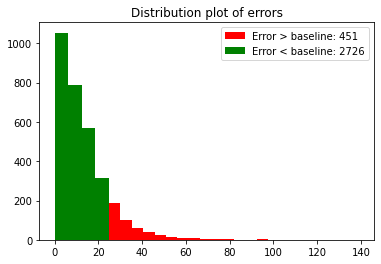

In [20]:
expr = bestEq
func = gp.compile(expr = expr, pset = pset)
predicted = [func(*slow_wind.iloc[i]) for i in range(len(slow_wind))]
forec = [forecast.iloc[i] for i in range(len(slow_wind))]
errors = [abs(i-j) for i,j in zip(predicted, forec)]
baseline = 24.92852089
errors = pd.DataFrame(errors, columns=['errors'])
bad_error = errors.loc[errors['errors']>baseline]
good_error = errors.loc[errors['errors']<baseline]
plt.hist(bad_error, color = 'r', label = f'Error > baseline: {len(bad_error)}', bins= int((bad_error.max()-bad_error.min())/5))
plt.hist(good_error, color = 'g', label = f'Error < baseline: {len(good_error)}', bins= int((good_error.max()-good_error.min())/5))
plt.legend()
plt.title('Distribution plot of errors')
plt.show()

In [15]:
# expr = 'add(speed_1d_1, add(add(add(sub(p_density_1d_1, log(speed_1d_1)), add(add(cos(add(add(log10(sin(log(add(cos(Bt_1d_1), speed_1d_2)))), add(log10(pow(sub(p_density_1d_1, sin(log(p_density_1d_3))), log10(-2))), -2)), add(cos(sqrt(speed_1d_1)), add(add(log10(sin(log(add(cos(p_density_1d_1), speed_1d_2)))), add(log10(sin(log(sqrt(speed_1d_1)))), -2)), log10(sin(log(add(p_density_1d_1, speed_1d_2)))))))), add(add(add(log10(sin(log(add(Bt_1d_1, pow(exp(3.141592653589793), log(speed_1d_1)))))), add(log10(pow(sub(p_density_1d_1, tan(asin(temperature_1d_2))), log10(add(-2, add(add(speed_carrington_1, By_1d_4), log10(sub(p_density_1d_1, p_density_1d_1))))))), -2)), add(cos(sqrt(speed_1d_1)), add(add(log10(sin(log(log(add(cos(p_density_1d_1), speed_1d_2))))), -2), log10(sin(tan(3.141592653589793)))))), acos(p_density_carrington_1))), log10(sin(log(add(cos(p_density_1d_1), speed_1d_2)))))), add(add(add(add(cos(sqrt(speed_1d_1)), add(add(log10(sin(log(add(Bt_1d_1, pow(exp(3.141592653589793), log(speed_1d_1)))))), -2), add(cos(sqrt(speed_1d_1)), add(add(log10(By_1d_1), -2), asin(atan(By_1d_1)))))), add(log10(speed_1d_2), -2)), sub(add(sub(p_density_1d_1, p_density_carrington_3), Bt_1d_1), p_density_carrington_1)), sub(p_density_1d_1, log(speed_1d_1)))), add(add(Bt_carrington_2, add(add(cos(Bt_1d_1), add(add(add(cos(Bt_1d_1), add(add(sin(Bx_carrington_2), add(add(log10(Bx_carrington_2), add(-2, log10(By_1d_1))), log10(acos(add(p_density_1d_3, Bz_1d_2))))), atan(Bz_carrington_1))), add(add(cos(sqrt(speed_1d_1)), -2), add(cos(sqrt(speed_1d_1)), add(add(log10(-2), -2), asin(atan(By_1d_1)))))), add(add(cos(sqrt(speed_1d_1)), add(add(log10(exp(3.141592653589793)), -2), log10(Bt_1d_1))), atan(sin(log(add(p_density_1d_1, speed_1d_2))))))), -2)), protectedDiv(sub(add(add(add(sub(p_density_1d_1, log(add(-2, speed_1d_2))), sub(sub(p_density_1d_1, sin(sub(sub(sqrt(speed_1d_1), sin(log10(pow(sub(p_density_1d_1, p_density_1d_3), Bx_1d_4)))), log(acos(p_density_1d_1))))), log(add(sub(add(sin(By_1d_1), Bt_1d_1), p_density_carrington_1), speed_1d_2)))), add(add(log10(sin(log(add(cos(Bt_1d_1), speed_1d_2)))), add(log10(pow(sub(p_density_1d_1, sin(log(p_density_1d_3))), log10(-2))), -2)), add(cos(sqrt(speed_1d_1)), add(add(log10(sin(log(add(cos(p_density_1d_1), speed_1d_2)))), add(log10(sin(log(sqrt(speed_1d_1)))), -2)), log10(sin(log(add(p_density_1d_1, speed_1d_2)))))))), protectedDiv(sub(add(cos(Bt_1d_1), Bt_1d_1), add(sin(sub(Bt_1d_1, log(p_density_1d_1))), p_density_1d_3)), asin(add(speed_1d_3, Bz_1d_4)))), log(add(acos(add(-2, sub(sqrt(speed_1d_1), sin(log10(pow(sub(p_density_1d_1, p_density_1d_3), Bx_1d_4)))))), speed_1d_2))), asin(sqrt(atan(add(sin(asin(sqrt(p_density_carrington_3))), speed_1d_2))))))))'
# func = gp.compile(expr = expr, pset = pset)
# predicted = [func(*slow_wind.iloc[i]) for i in range(len(slow_wind))]
# forec = [forecast.iloc[i] for i in range(len(slow_wind))]
# errors = [abs(i-j) for i,j in zip(predicted, forec)]
# baseline = 24.92852089
# errors = pd.DataFrame(errors, columns=['errors'])
# bad_error = errors.loc[errors['errors']>baseline]
# good_error = errors.loc[errors['errors']<baseline]
# plt.hist(bad_error, color = 'r', label = f'Error > baseline: {len(bad_error)}', bins= int((bad_error.max()-bad_error.min())/5))
# plt.hist(good_error, color = 'g', label = f'Error < baseline: {len(good_error)}', bins= int((good_error.max()-good_error.min())/5))
# plt.legend()
# plt.title('Distribution plot of errors')
# plt.show()